In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import truncnorm
from scipy.optimize import minimize 
from scipy.stats import norm

class EMTruncatedGaussianWithNNet:
    def __init__(self, x, betahat, sd_noise, hidden_dim=16, lr=0.01, max_iter=100, tol=1e-6, truncation_point=0, tau_squared=None):
        """
        EM algorithm for a mixture model with a point mass at 0 and a truncated Gaussian component.
        The mixture weights are modulated by a neural network.
        """
        # Ensure x is 2D
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        self.x = torch.tensor(x, dtype=torch.float32)
        self.betahat = betahat
        self.sd_noise = sd_noise
        self.max_iter = max_iter
        self.tol = tol
        self.truncation_point = truncation_point
        self.mu = np.mean(betahat)  # Initialize mean of the truncated Gaussian
        self.tau_squared = tau_squared if tau_squared is not None else np.var(betahat)  # Initialize variance

        # Neural network for \(\pi(x)\)
        self.pi_net = nn.Sequential(
            nn.Linear(self.x.shape[1], hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),  # Ensure output is in (0, 1)
        )
        self.optimizer = optim.Adam(self.pi_net.parameters(), lr=lr)


    def truncated_normal_pdf(self, x, mu, sigma):
        """
        Compute the PDF of a truncated normal distribution.
        """
        a, b = (self.truncation_point - mu) / sigma, np.inf  # Truncate below truncation_point
        pdf = truncnorm.pdf(x, a, b, loc=mu, scale=sigma)
        return pdf

    def e_step(self):
        """
        E-step: Compute posterior probabilities \(q_i\) for each data point.
        """
        # Predict \(\pi(x)\) using the neural network
        self.pi_net.eval()
        with torch.no_grad():
            pi_2 = self.pi_net(self.x).squeeze().numpy()
        pi_1 = 1 - pi_2

        # Total variance for the Gaussian component
        sigma_2_total = self.sd_noise**2 + self.tau_squared
        sigma = np.sqrt(sigma_2_total)

        # Compute likelihoods
        p1 = norm.pdf(self.betahat, 0, self.sd_noise)  # Point mass likelihood
        p2 = self.truncated_normal_pdf(self.betahat, self.mu, sigma)  # Truncated Gaussian likelihood

        # Posterior probabilities (responsibilities)
        q = (pi_2 * p2) / (pi_1 * p1 + pi_2 * p2 + 1e-8)  # Add epsilon for stability
        return q, pi_1, pi_2

    def m_step(self, q):
        """
        M-step: Update parameters \(\mu\), \(\tau^2\), and the neural network \(\pi(x)\).
        """
        # Update \(\mu\) (optimize Equation 23)
        def objective(mu):
            sigma_2_total = self.sd_noise**2 + self.tau_squared
            sigma = np.sqrt(sigma_2_total)
            pdf_vals = self.truncated_normal_pdf(self.betahat, mu, sigma)
            log_likelihood = np.sum(q * np.log(pdf_vals + 1e-8))
            return -log_likelihood  # Minimize the negative log-likelihood

        res = minimize(objective, self.mu, method="L-BFGS-B")
        self.mu = res.x[0]

        # Update \(\tau^2\) (Equation 25)
        self.tau_squared = np.sum(q * (self.betahat - self.mu) ** 2) / np.sum(q)
        self.tau_squared = max(self.tau_squared, 1e-8)  # Ensure non-negative variance

        # Update the neural network \(\pi(x)\)
        self.pi_net.train()
        q_tensor = torch.tensor(q, dtype=torch.float32)
        for _ in range(100):  # Fixed number of optimization steps
            self.optimizer.zero_grad()
            pi_2 = self.pi_net(self.x).squeeze()
            loss = nn.BCELoss()(pi_2, q_tensor)  # Binary cross-entropy loss
            loss.backward()
            self.optimizer.step()

    def run(self):
        """
        Run the EM algorithm until convergence.

        Returns:
        - mu: Estimated mean of the truncated Gaussian component.
        - tau_squared: Estimated variance of the truncated Gaussian component.
        - pi_net: Trained neural network for \(\pi(x)\).
        """
        for iteration in range(self.max_iter):
            # E-step
            q, pi_1, pi_2 = self.e_step()

            # Save old parameters to check for convergence
            old_params = np.array([self.mu, self.tau_squared])

            # M-step
            self.m_step(q)

            # Check convergence
            new_params = np.array([self.mu, self.tau_squared])
            if np.linalg.norm(new_params - old_params) < self.tol:
                print(f"Converged in {iteration + 1} iterations.")
                break
        else:
            print("Maximum iterations reached without convergence.")

        return self.pi_net, self.mu, self.tau_squared

 

Maximum iterations reached without convergence.
Estimated μ: 3.0289817903419585, True μ: 3.0
Estimated τ²: 1.9788099605852327, True τ²: 1.5


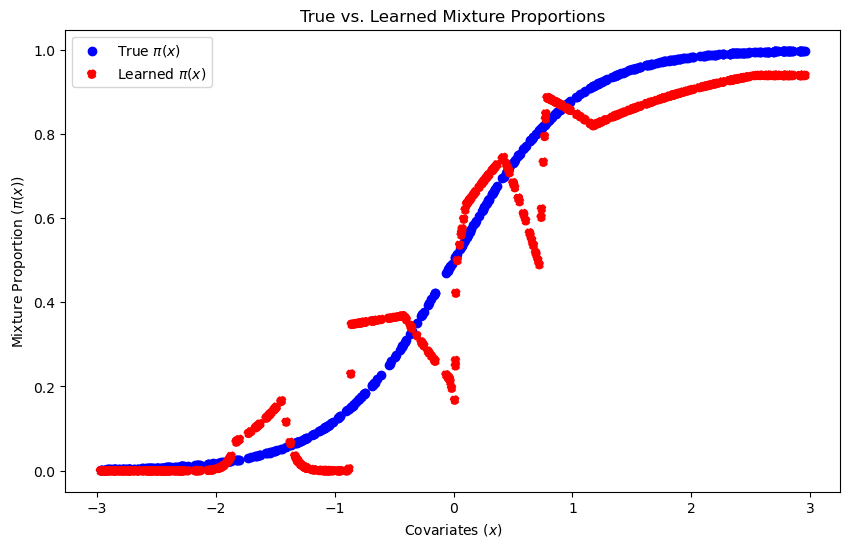

In [5]:
if __name__ == "__main__":
    np.random.seed(42)
    n_samples = 500
    true_mu = 3.0
    true_tau_squared = 1.5
    truncation_point = 0
    true_sd_noise = 1.0

    # Generate covariates
    x = np.random.uniform(-3, 3, n_samples)

    # True mixture probabilities
    pi_true = 1 / (1 + np.exp(-2 * x))  # Sigmoid function modulated by covariates

    # Generate observed data
    z = np.zeros(n_samples)
    for i in range(n_samples):
        if np.random.rand() < pi_true[i]:  # Sample from truncated Gaussian
            z[i] = truncnorm.rvs(
                (truncation_point - true_mu) / np.sqrt(true_tau_squared),
                np.inf,
                loc=true_mu,
                scale=np.sqrt(true_tau_squared),
            )
        else:  # Sample from point mass at 0
            z[i] = 0

    # Add noise to the observed data
    betahat = z + np.random.normal(0, true_sd_noise, n_samples)

    # Initialize EM parameters
    em = EMTruncatedGaussianWithNNet(x, betahat, sd_noise=true_sd_noise, tau_squared=2.0)

    # Run EM algorithm
    pi_net, mu, tau_squared = em.run()

    # Print results
    print(f"Estimated μ: {mu}, True μ: {true_mu}")
    print(f"Estimated τ²: {tau_squared}, True τ²: {true_tau_squared}")

    # Visualize learned \(\pi(x)\)
    with torch.no_grad():
        x_tensor = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)
        pi_learned = pi_net(x_tensor).squeeze().numpy()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.scatter(x, pi_true, label="True $\pi(x)$", color="blue")
    plt.scatter(x, pi_learned, label="Learned $\pi(x)$", color="red", linestyle="--")
    plt.xlabel("Covariates ($x$)")
    plt.ylabel("Mixture Proportion ($\pi(x)$)")
    plt.legend()
    plt.title("True vs. Learned Mixture Proportions")
    plt.show()


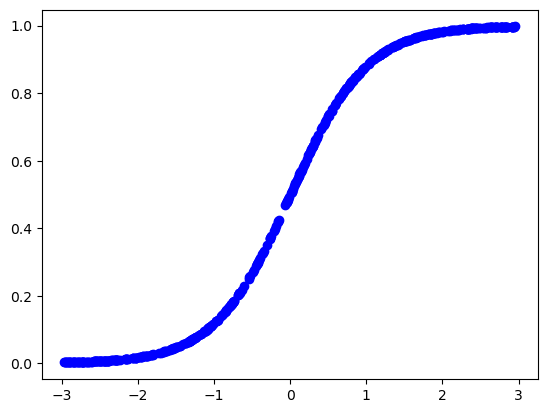

In [ ]:

plt.scatter(x, pi_true, label="True $\pi(x)$", color="blue")